In [3]:
## SIR model
## Author: Yran Jing
## Date: 2020-02-03

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

class SEIR:
    """
    'eons' (number of time points to model, default 1000)
    'Susceptible' (number of susceptible individuals at time 0, default 950)
    'Exposed' (number of individuals during incubation period)
    'Infected' (number of infected individuals at time 0, default 50)
    'Resistant' (number of resistant individuals at time 0, default 0)
    'rateSI' (base rate 'beta' from S to E, default 0.05)
    'rateIR' (base rate 'gamma' from I to R, default 0.01)
    'rateAl' (base rate of isolation 'altha', from E to I, default 0.1)
    """
    def __init__(self, eons=1000, Susceptible=950, Exposed = 100, Infected=50, Resistant=0, rateSI=0.05, rateIR=0.01, rateAl = 0.1):
        self.eons = eons
        self.Susceptible = Susceptible
        self.Exposed = Exposed
        self.Infected = Infected
        self.Resistant = Resistant
        self.rateSI = rateSI
        self.rateIR = rateIR
        self.rateAl = rateAl
        self.numIndividuals = Susceptible + Infected + Resistant + Exposed # total population
        self.results = None
        self.modelRun = False

    def run(self, death_rate):
        Susceptible = [self.Susceptible]
        Exposed = [self.Exposed]
        Infected = [self.Infected]
        Resistant = [self.Resistant]

        for step in range(1, self.eons):
            S_to_E = (self.rateSI * Susceptible[-1] * Infected[-1]) / self.numIndividuals
            E_to_I = (self.rateAl * Exposed[-1])
            I_to_R = (Infected[-1] * self.rateIR)
            
            Susceptible.append(Susceptible[-1] - S_to_E)
            Exposed.append(Exposed[-1] + S_to_E - E_to_I)
            Infected.append(Infected[-1] + E_to_I - I_to_R)
            Resistant.append(Resistant[-1] + I_to_R)
        
        # Death is death_rate* recovery group
        Death = list(map(lambda x: (x * death_rate), Resistant))
        # Heal is removed - Death
        Heal = list(map(lambda x: (x * (1-death_rate)), Resistant))
        self.results = pd.DataFrame.from_dict({'Time':list(range(len(Susceptible))),
            'Susceptible':Susceptible, 'Exposed': Exposed, 'Infected':Infected, 'Resistant':Resistant,
                                               'Death':Death, 'Heal': Heal},
            orient='index').transpose()
        self.modelRun = True
        return self.results

    def plot(self, title, ylabel, xlabel):
        if self.modelRun == False:
            print('Error: Model has not run. Please call SIR.run()')
            return
        print("Maximum infected case: ",
              format(int(max(self.results['Infected']))))
        fig, ax = plt.subplots(figsize=(10,6))
        plt.plot(self.results['Time'], self.results['Susceptible'], color='blue')
        plt.plot(self.results['Time'], self.results['Infected'], color='red')
        plt.plot(self.results['Time'], self.results['Exposed'], color='orange')
        plt.plot(self.results['Time'], self.results['Resistant'], color='palegreen')
        plt.plot(self.results['Time'], self.results['Heal'], color='green')
        plt.plot(self.results['Time'], self.results['Death'], color='grey')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['Susceptible','Infected','Exposed','Removed', 'Heal', 'Death'], prop={'size': 12}, bbox_to_anchor=(0.5, 1.02), ncol=6, fancybox=True, shadow=True)
        plt.title(title, fontsize = 20)
        plt.show()
        
    def plot_noSuscep(self, title, ylabel, xlabel):
        if self.modelRun == False:
            print('Error: Model has not run. Please call SIR.run()')
            return
        print("Maximum infected case: ",
              format(int(max(self.results['Infected']))))
        fig, ax = plt.subplots(figsize=(10,6))
        plt.plot(self.results['Time'], self.results['Infected'], color='red')
        plt.plot(self.results['Time'], self.results['Resistant'], color='palegreen')
        plt.plot(self.results['Time'], self.results['Exposed'], color='orange')
        plt.plot(self.results['Time'], self.results['Heal'], color='green')
        plt.plot(self.results['Time'], self.results['Death'], color='grey')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['Infected','Removed','Exposed','Heal','Death'], prop={'size': 12}, bbox_to_anchor=(0.5, 1.02), ncol=5, fancybox=True, shadow=True)
        plt.title(title, fontsize = 20)
        plt.show()

In [4]:
import numpy as np
import scipy.optimize as optimization
import pandas as pd
import pandas
#from SEIR_model import SEIR

class Estimate_parameter:
    """
    Estimate other parameters: 
            beta in SIR model and R0(basic reproduction number)
    """
    def __init__(self, nu: float, k: int, t: np.ndarray, I: np.ndarray):
        self.nu = nu
        self.k = k # the number of people a confirmed case contacts daily
        self.t = t # time step
        self.I = I  # observation
        # Estimated beta
        self.beta = self._estimate_beta()
        # self.R0
        self.R0 = self._estimate_R0()
        
    def func(self, t: np.ndarray, b):
        """
        K is the mean number of people a confirmed case contacts daily
        """
        print(t)
        return np.exp((self.k*b-self.nu)*t)

    def _estimate_transmission_probablity(self):
        """
        Estimate the transmission probablity by non-linear OLS
        """
        return optimization.curve_fit(self.func, self.t, 
                                      self.I, maxfev=1000)[0][0]
    def _estimate_beta(self):
        """
        Estimate beta of SIR model
        """
        return self.k * self._estimate_transmission_probablity()
    
    def _estimate_R0(self):
        """
        Estimate R0(basic reproduction number)
        """
        return (self.beta)/self.nu
    
    def __str__(self): 
        """
        Representation
        """
        return f"""Estimate the transmission probablity: {round(self._estimate_transmission_probablity(), 2)} 
Estimated R0(basic reproduction number): {round(self.R0,1)}
"""



class Estimate_Wuhan_Outbreak(Estimate_parameter):
    
    def __init__(self, Est: Estimate_parameter, k: int, N: int,
                E0: int, I0: int, R0: int, T: int, econ: int):
        self.Est = Est 
        print(self.Est) # print R0 
        self.k = k # the number of people one case contacts daily, which nflunenced by government force
        self.N = N
        self.E0 = E0 # initial number of Enfective cases
        self.I0 = I0 # initial number of recovered cases
        self.R0 = R0
        self.S0 = N - E0 - I0 - R0# initial number of suspective cases
        self.alpha = 1/T # T is the mean of incubation period
        self.econ = econ
        self.model = None
        
        
    def _run_SIER(self,title:str, ylabel:str, xlabel:str, death_rate: float, show_Sus = True) -> pandas.core.frame.DataFrame:
        """
        Run SIER model
        """
        Est_beta = self.Est._estimate_transmission_probablity()*self.k
        sier = SEIR(eons=self.econ, Susceptible=self.N-self.E0-self.I0-self.R0, Exposed = self.E0, 
                    Infected=self.I0, Resistant=self.R0, rateSI=Est_beta, rateIR=self.Est.nu, 
                    rateAl = self.alpha)
        result = sier.run(death_rate)
        # Draw plot
        if show_Sus:
            sier.plot(title, ylabel, xlabel)
        else:
            sier.plot_noSuscep(title, ylabel, xlabel)
        
        self.model = sier
        return result

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

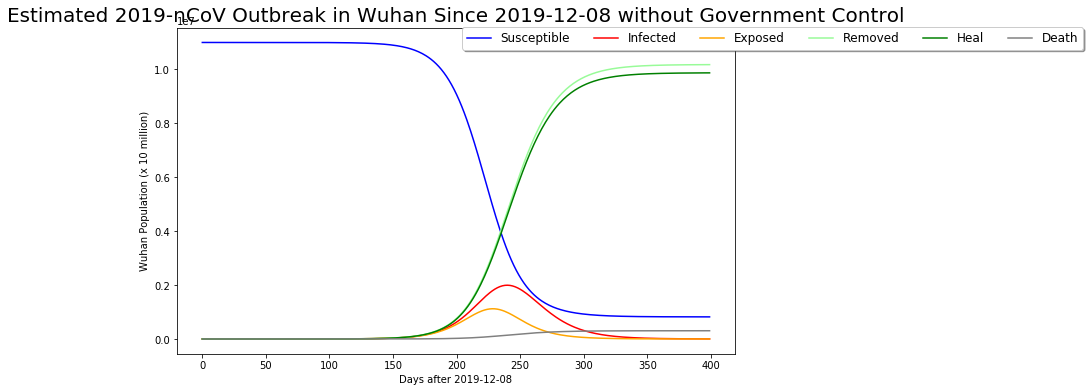



Baseline after 23 Jan
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 4

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

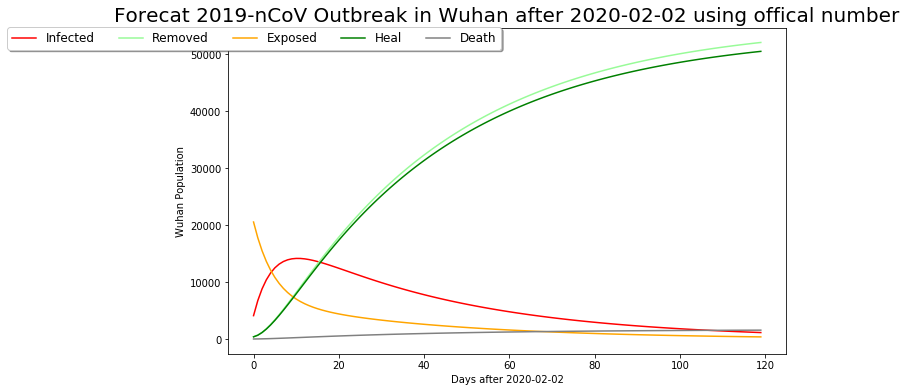



case 1
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

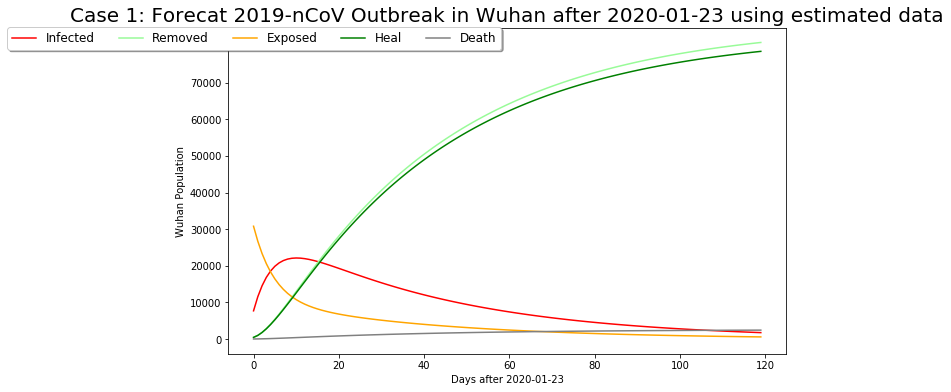



Case 2
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

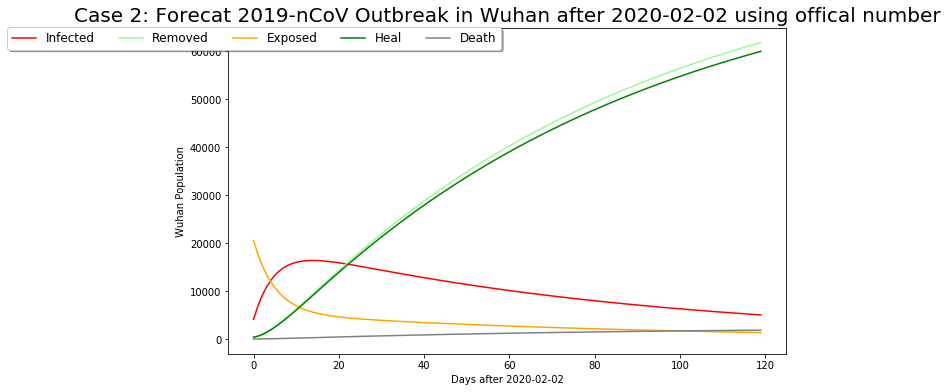



Case 3
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

Maximum infected case:  80491


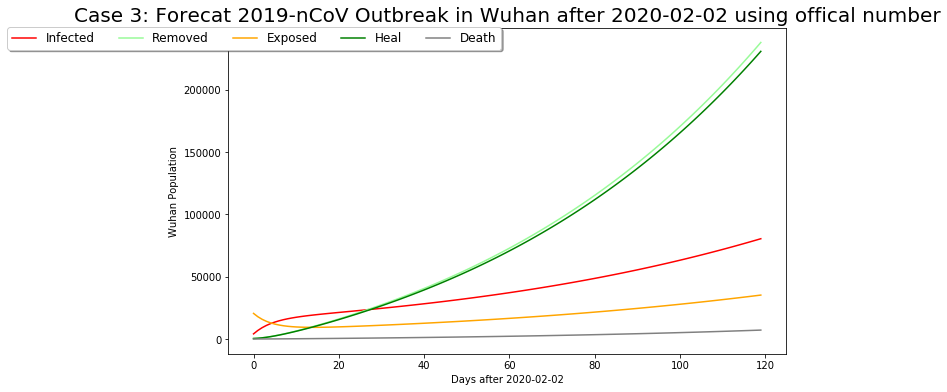



Case 4
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

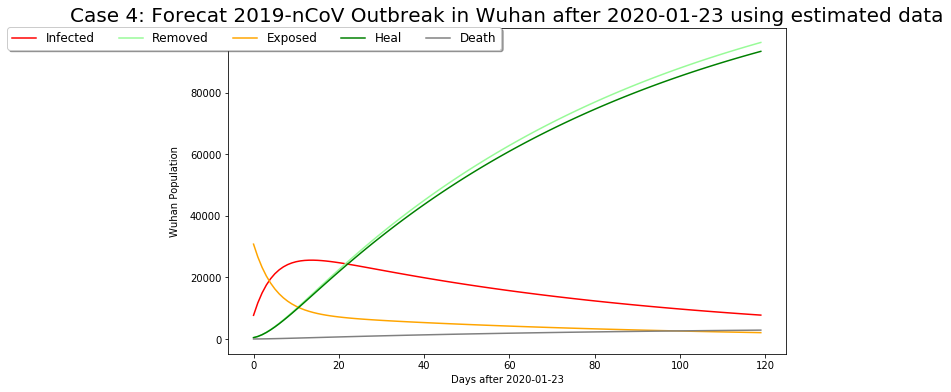



Case 5
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46. 47. 48. 49.]
[ 0. 45. 46.

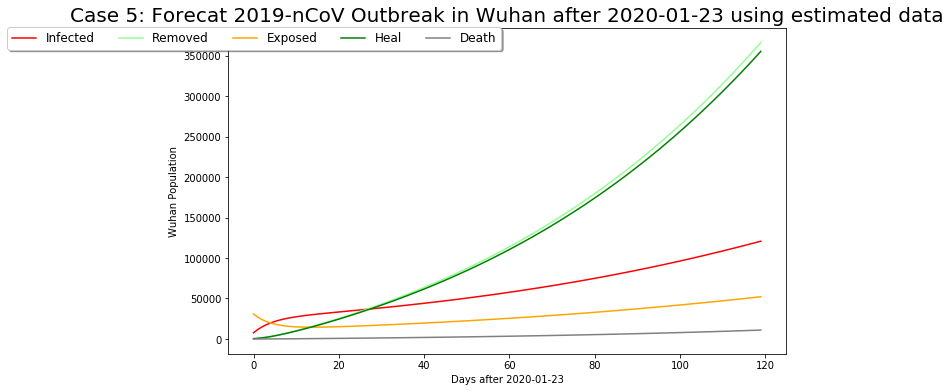

In [13]:
"""
Data from Chinese Center for Disease Control and Prevention (DOC) 
"""
# 2019-12-08 is the first date, when find the first case. 
t = np.asarray([0, 45, 46,47,48,49])  # time
I = np.asarray([1,198,218,320,478,639]) # number of official confirmed cases


def main():
    
    # estimate R0 and beta
    Est = Estimate_parameter(nu = 1/14, k = 5, t = t, I = I)
    print(Est)
    
    # run model before 23 Jan
    """
    Baseline: before 23 Jan 
    
    2019-12-08: 
    I0 = 1: 1confirmed cases
    E0 = 5: Based on the data in Early Transmission Dynamics report, there are 5 cases were confirmed 
    in the next 7 days after the first case. So E0 = 5. 
    R0 = 0: no people died or recover
    """
    print("\n\nBaseline before 23 Jan")
    baseline = Estimate_Wuhan_Outbreak(Est, k = 5, N=11000000,
                    E0 = 5, I0 = 1, R0 = 0, T=7, econ = 400)
    result = baseline._run_SIER('Estimated 2019-nCoV Outbreak in Wuhan Since 2019-12-08 without Government Control',
            'Wuhan Population (x 10 million)', 'Days after 2019-12-08', death_rate = 0.03)
    
    
    # run model after 23 
    """
    after Wuhan shut down (after 23 Jan)
    beta: The contact rate is half than before
    N = 9000000
    k = 1 # effective goverment control and individual protection
    
    2020 Feb 02:
    R0 = 175+224. curedCount: 175, deadCount: 224
    I0 = 4109 # offical number on 02 Feb
    
    Suppose E0 = I0*5: the number of ppl in incubation is 5 times the confirmed cases.
    """
    print("\n\nBaseline after 23 Jan")
    case1 = Estimate_Wuhan_Outbreak(Est, k = 1, N=9000000,
                    E0 = 4109 * 5, I0 = 4109, R0 = (175+224), T=7, econ = 120)
    result2 = case1._run_SIER('Forecat 2019-nCoV Outbreak in Wuhan after 2020-02-02 using offical number',
            'Wuhan Population','Days after 2020-02-02', death_rate = 0.03, show_Sus = False)
    
    
    #Sensitvity analysis
    """
    case 1:
    S0 using the estimated result from model 1
    There are 46000 cases in wuhan until 23 Jan:
       Assume the infected case are 20% only
       The lefs are in incubation period
    Assume the death rate = cure rate = 3% 
    """
    print("\n\ncase 1")
    N = 9000000
    I0 = 38500 *1/5
    E0 = 38500 * 4/5
    R0 = I0 * (0.03+0.03) # suppose the death rate is 3% (official), equal to cure rate
    k = 1
    # estimate beta and R0
    Est_beta = Est._estimate_transmission_probablity()*k
    
    case2 = Estimate_Wuhan_Outbreak(Est, k = 1, N=9000000,
                    E0 = E0, I0 = I0, R0 = R0, T=7, econ = 120)
    result3 = case2._run_SIER('Case 1: Forecat 2019-nCoV Outbreak in Wuhan after 2020-01-23 using estimated data',
            'Wuhan Population','Days after 2020-01-23', death_rate = 0.03, show_Sus = False)
    
    
    """
    case2: Assume the mean duration of the infection is 30 days
    """
    print("\n\nCase 2")
    Est = Estimate_parameter(nu = 1/20, k = 5, t = t, I = I)
    
    Est_beta = Est._estimate_transmission_probablity()*k
    
    case2 = Estimate_Wuhan_Outbreak(Est, k = 1, N=9000000,
                    E0 = 4109 * 5, I0 = 4109, R0 = (175+224), T=7, econ = 120)
    result3 = case2._run_SIER('Case 2: Forecat 2019-nCoV Outbreak in Wuhan after 2020-02-02 using offical number',
            'Wuhan Population','Days after 2020-02-02', show_Sus = False, death_rate = 0.03)
    
    
    
    """
    case3: Assume k = 2, rather than 1, 
             since some cases cannot be detected correctly or immediately, Also not perfect isolation
    """
    print("\n\nCase 3")
    Est = Estimate_parameter(nu = 1/20, k = 5, t = t, I = I)
    
    Est_beta = Est._estimate_transmission_probablity()*k
    
    case2 = Estimate_Wuhan_Outbreak(Est, k = 2, N=9000000,
                    E0 = 4109 * 5, I0 = 4109, R0 = (175+224), T=7, econ = 120)
    result3 = case2._run_SIER('Case 3: Forecat 2019-nCoV Outbreak in Wuhan after 2020-02-02 using offical number',
            'Wuhan Population','Days after 2020-02-02', show_Sus = False, death_rate = 0.03)
    
    
    
    """
    case4: case 1 + case 2
    """
    print('\n\nCase 4')
    Est = Estimate_parameter(nu = 1/20, k = 5, t = t, I = I)
    
    N = 9000000
    I0 = 38500 *1/5
    E0 = 38500 * 4/5
    R0 = I0 * (0.03+0.03) # suppose the death rate is 3% (official), equal to cure rate
    k = 1
    # estimate beta and R0
    Est_beta = Est._estimate_transmission_probablity()*k
    
    case2 = Estimate_Wuhan_Outbreak(Est, k = 1, N=9000000,
                    E0 = E0, I0 = I0, R0 = R0, T=7, econ = 120)
    result3 = case2._run_SIER('Case 4: Forecat 2019-nCoV Outbreak in Wuhan after 2020-01-23 using estimated data',
            'Wuhan Population','Days after 2020-01-23', show_Sus = False, death_rate = 0.03,)
    

    
    """
    case5: case 1 + case 2 + case 3
    """
    print('\n\nCase 5')
    Est = Estimate_parameter(nu = 1/20, k = 5, t = t, I = I)
    
    N = 9000000
    I0 = 38500 *1/5
    E0 = 38500 * 4/5
    R0 = I0 * (0.03+0.03) # suppose the death rate is 3% (official), equal to cure rate
    k = 1
    # estimate beta and R0
    Est_beta = Est._estimate_transmission_probablity()*k
    
    case2 = Estimate_Wuhan_Outbreak(Est, k = 2, N=9000000,
                    E0 = E0, I0 = I0, R0 = R0, T=7, econ = 120)
    result3 = case2._run_SIER('Case 5: Forecat 2019-nCoV Outbreak in Wuhan after 2020-01-23 using estimated data',
            'Wuhan Population','Days after 2020-01-23', show_Sus = False, death_rate = 0.03,)

    
                
if __name__ == '__main__':
    main()